# VoxCeleb trainer performance measures for pretrained ResNet34 on different type of audio signals

**Src**: https://github.com/clovaai/voxceleb_trainer

In [1]:
from google.colab import drive

ROOT = '/content/drive'

drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jul 29 05:56:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [ ]:
!pip install -q torch==1.5.1
!pip install -q torchaudio==0.5.1

     |████████████████████████████████| 3.2MB 3.5MB/s 


In [3]:
import sys, time, os, argparse, socket, random
import numpy as np
import pdb
import torch
import glob
from tuneThreshold import tuneThresholdfromScore
from SpeakerNet import SpeakerNet
from DatasetLoader import DatasetLoader
from utils import add_noise
import librosa
from DWaveNet import DWaveNet
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Default parameters
## Data loader
* parser.add_argument('--max_frames', type=int, default=200,  help='Input length to the network');
* parser.add_argument('--batch_size', type=int, default=200,  help='Batch size');
* parser.add_argument('--max_seg_per_spk', type=int, default=100, help='Maximum number of utterances per speaker per epoch');
* parser.add_argument('--nDataLoaderThread', type=int, default=5, help='Number of loader threads');

## Training details
* parser.add_argument('--test_interval', type=int, default=10, help='Test and save every [test_interval] epochs');
* parser.add_argument('--max_epoch',      type=int, default=500, help='Maximum number of epochs');
* parser.add_argument('--trainfunc', type=str, default="",    help='Loss function');
* parser.add_argument('--optimizer', type=str, default="adam", help='sgd or adam');

## Learning rates
* parser.add_argument('--lr', type=float, default=0.001,      help='Learning rate');
* parser.add_argument("--lr_decay", type=float, default=0.95, help='Learning rate decay every [test_interval] epochs');

## Loss functions
* parser.add_argument("--hard_prob", type=float, default=0.5, help='Hard negative mining probability, otherwise random, only for some loss functions');
* parser.add_argument("--hard_rank", type=int, default=10,    help='Hard negative mining rank in the batch, only for some loss functions');
* parser.add_argument('--margin', type=float,  default=1,     help='Loss margin, only for some loss functions');
* parser.add_argument('--scale', type=float,   default=15,    help='Loss scale, only for some loss functions');
* parser.add_argument('--nSpeakers', type=int, default=5994,  help='Number of speakers in the softmax layer for softmax-based losses, utterances per speaker per iteration for other losses');

## Load and save
* parser.add_argument('--initial_model',  type=str, default="", help='Initial model weights');
* parser.add_argument('--save_path',      type=str, default="./data/exp1", help='Path for model and logs');

## Training and test data
* parser.add_argument('--train_list', type=str, default="",   help='Train list');
* parser.add_argument('--test_list',  type=str, default="",   help='Evaluation list');
* parser.add_argument('--train_path', type=str, default="voxceleb2", help='Absolute path to the train set');
* parser.add_argument('--test_path',  type=str, default="voxceleb1", help='Absolute path to the test set');

## For test only
* parser.add_argument('--eval', dest='eval', action='store_true', help='Eval only')

## Model definition
* parser.add_argument('--model', type=str,        default="",     help='Name of model definition');
* parser.add_argument('--encoder_type', type=str, default="SAP",  help='Type of encoder');
* parser.add_argument('--nOut', type=int,         default=512,    help='Embedding size in the last FC layer');

# Tuned parameters from the repo author
* -- model "ResNetSE34L"
* -- trainfunc "angleproto"
* -- max_frames = 300
* -- save_path
* -- test_list
* -- test_path
* -- initial_model "baseline_lite_ap.model"

# Init pretrained model

In [ ]:
# params
eval = True
model = 'ResNetSE34L'
trainfunc = 'angleproto'
save_path = '/content/drive/My Drive/Stage-Imaging/'
max_frames = 300
batch_size = 200
max_seg_per_spk = 100
nDataLoaderThread = 5
max_epoch = 500
optimizer = 'adam'
hard_prob = .5
hard_rank = 10
margin = 1
scale = 15
nSpeakers = 5994
test_list = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test.txt'
test_list_25 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_2.5.txt'
test_list_25_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_2.5_denoised_v2.txt'
test_list_75 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_7.5.txt'
test_list_75_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_7.5_denoised_v2.txt'
test_list_125 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_12.5.txt'
test_list_125_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_12.5_denoised_v2.txt'
test_list_175 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_17.5.txt'
test_list_175_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_17.5_denoised_v2.txt'
test_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/'
initial_model = 'baseline_lite_ap.model'
encoder_type = 'SAP'
nOut = 512
lr = 0.001


# defaults
lr_decay = .95
test_interval = 10

In [ ]:
s = SpeakerNet(model = model, trainfunc = trainfunc, max_frames = max_frames, batch_size = batch_size, max_seg_per_spk = max_seg_per_spk, nDataLoaderThread = nDataLoaderThread, encoder_type = encoder_type, nOut = nOut,
               test_interval = test_interval, max_epoch = max_epoch, optimizer = optimizer, lr = lr, lr_decay = lr_decay, hard_prob = hard_prob, hard_rank = hard_rank, margin = margin, scale = scale,
               nSpeakers = nSpeakers)

it = 1
prevloss = float("inf")
sumloss = 0

Embedding size is 512, encoder SAP.
Initialised AngleProto


In [ ]:
## Load model weights
modelfiles = glob.glob('%s/model0*.model'%save_path)
modelfiles.sort()

if len(modelfiles) >= 1:
    s.loadParameters(modelfiles[-1]);
    print("Model %s loaded from previous state!"%modelfiles[-1]);
    it = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][5:]) + 1
elif(initial_model != ""):
    s.loadParameters(initial_model);
    print("Model %s loaded!"%initial_model);

for ii in range(0, it-1):
    if ii % test_interval == 0:
        clr = s.updateLearningRate(lr_decay)

Model baseline_lite_ap.model loaded!


**Evaluation measure EER**:
* Normal audio &rarr; **2.2322**
* Noisy audio SNR 2.5 &rarr; **11.9459** - **16.0021** &rarr; **31.3892**
* Noisy audio SNR 7.5 &rarr; **6.8293** - **10.8006** &rarr; **27.7678**
* Noisy audio SNR 12.5 &rarr; **4.2206** - **8.3775** &rarr; **25.1962**
* Noisy audio SNR 17.5 &rarr; **3.1336** - **7.1050** &rarr; **23.5366**

In [ ]:
values = [2.23, 11.94, 6.82, 4.22, 3.13, 0.0, 16.00, 10.80, 8.37, 7.10, 0.0, 31.38, 27.76, 25.19, 23.53]
type_of_audio = ['clean', 'snr 2.5', 'snr 7.5', 'snr 12.5', 'snr 17.5', 'clean', 'snr 2.5', 'snr 7.5', 'snr 12.5', 'snr 17.5', 'clean', 'snr 2.5', 'snr 7.5', 'snr 12.5', 'snr 17.5']
denoised_or_not = ['pure','pure','pure','pure','pure','denoised','denoised','denoised','denoised','denoised', 'denoised_v2', 'denoised_v2', 'denoised_v2', 'denoised_v2', 'denoised_v2']

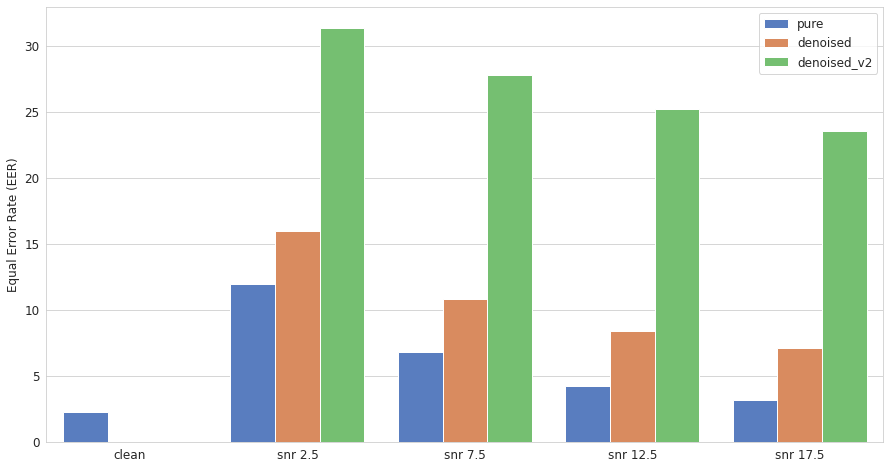

In [ ]:
plt.figure(figsize = (15, 8))
sns.set_style('whitegrid')
sns.barplot(x = np.array(type_of_audio), y = np.array(values), hue = np.array(denoised_or_not), palette = 'muted')
plt.ylabel('Equal Error Rate (EER)', fontdict = {'fontsize':12})
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize = 12)
#plt.savefig('../plots/SpeakerVerificationPerformanceV2.png')

# Measures on test data

## Normal audio

In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 1.31 Hz, embed size 512
Computing 37700: 1925.20 Hz

EER 2.2322


## Noisy audio SNR 2.5

In [ ]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 2.5

start = time.time()
with open('noise_logfile_snr2.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 2.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Making

In [ ]:
with open('veri_test_2.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_2.5.wav')
    files[2] = files[2].replace('.wav', '_2.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_25, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 1.91 Hz, embed size 512
Computing 37700: 2956.88 Hz

EER 11.9459


## Noisy audio SNR 7.5

In [ ]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 7.5

start = time.time()
with open('noise_logfile_snr7.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 7.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Making

In [ ]:
with open('veri_test_7.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_7.5.wav')
    files[2] = files[2].replace('.wav', '_7.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_75, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.61 Hz, embed size 512
Computing 37700: 2857.83 Hz

EER 6.8293


## Noisy audio SNR 12.5

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 12.5

start = time.time()
with open('noise_logfile_snr12.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 12.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Makin

In [ ]:
with open('veri_test_12.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_12.5.wav')
    files[2] = files[2].replace('.wav', '_12.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_125, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 3.05 Hz, embed size 512
Computing 37700: 3016.88 Hz

EER 4.2206


## Noisy audio SNR 17.5

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 17.5

start = time.time()
with open('noise_logfile_snr17.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 17.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Makin

In [ ]:
with open('veri_test_17.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_17.5.wav')
    files[2] = files[2].replace('.wav', '_17.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_175, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.93 Hz, embed size 512
Computing 37700: 2916.59 Hz

EER 3.1336


### Concat noise logfiles

In [ ]:
filenames = ['noise_logfile_snr2.5.txt', 'noise_logfile_snr7.5.txt', 'noise_logfile_snr12.5.txt', 'noise_logfile_snr17.5.txt']
with open('logfiles/noise_logfile.txt', 'w') as outfile:
    for fname in filenames:
        with open('logfiles/'+fname) as infile:
            for line in infile:
                outfile.write(line)

print('Wrote noise logfile..')

Wrote noise logfile..


## Denoised audio

### WaveNet

In [ ]:
# main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
# for folder in os.listdir(main_path):
#   for video in os.listdir(os.path.join(main_path, folder)):
#     if os.path.isdir(os.path.join(main_path, folder, video, 'denoised')):
#       pass
#     else:
#       os.mkdir(os.path.join(main_path, folder, video, 'denoised'))

# print('Made subdirs...')

In [4]:
model = DWaveNet(in_channels = 1, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(2048, 256))

In [5]:
pretrain_model_pth = "../log/denoising/wavenet4/model_best.pth.tar"

if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = model.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))

loading pre-trained model from ../log/denoising/wavenet4/model_best.pth.tar


In [ ]:
to_exclude = ['id10280', 'id10279', 'id10308', 'id10276']#, 'id10275', 'id10309', 'id10274',
              #'id10307', 'id10273', 'id10272']#, 'id10306']#, 'id10305', 'id10284', 'id10304',
#               'id10303', 'id10278', 'id10271', 'id10302', 'id10301', 'id10300', 'id10298',
#                'id10297', 'id10296', 'id10295', 'id10294', 'id10292', 'id10290', 'id10287',
#               'id10286', 'id10285', 'id10283', 'id10282', 'id10281', 'id10277', 'id10270']#,
#               'id10288', 'id10289', 'id10291', 'id10299', 'id10293']

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'

snr = 17.5
sample_rate = 16000
model = model.cuda()
model = model.eval()
if snr < 10:
  idx = -13
else:
  idx = -14

count = 0
start = time.time()
for folder in os.listdir(main_path):
  #if folder not in to_exclude:
  print('Denoising audio files for {}'.format(folder))
  for video in os.listdir(os.path.join(main_path, folder)):
    for file in os.listdir(os.path.join(main_path, folder, video)):
      if os.path.isfile(os.path.join(main_path, folder, video, file)):
        if "_"+str(snr)+"." in file:
          noisy_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
          #noisy_audio = torch.FloatTensor(noisy_audio).unsqueeze(0).unsqueeze(0).cuda()
          noisy_audio = torch.from_numpy(noisy_audio).unsqueeze(0).unsqueeze(0).cuda()
          #print(noisy_audio)
          #print(noisy_audio.size())
          with torch.no_grad():
            denoised_audio = model(noisy_audio)
          denoised_audio = denoised_audio.squeeze(0).squeeze(0).cpu().numpy()
          output_path = os.path.join(main_path, folder, video, file[:idx], 'denoised', file[idx:-4]+'_v2'+file[-4:])
          #print(output_path)
          librosa.output.write_wav(output_path, denoised_audio, sr = sample_rate)
          count += 1

end = time.time()
print('Made {} denoised audios in {:.2f} min'.format(count, (end-start)/60))

Denoising audio files for id10280
Denoising audio files for id10279
Denoising audio files for id10308
Denoising audio files for id10276
Denoising audio files for id10275
Denoising audio files for id10309
Denoising audio files for id10274
Denoising audio files for id10307
Denoising audio files for id10273
Denoising audio files for id10272
Denoising audio files for id10306
Denoising audio files for id10305
Denoising audio files for id10284
Denoising audio files for id10304
Denoising audio files for id10303
Denoising audio files for id10278
Denoising audio files for id10271
Denoising audio files for id10302
Denoising audio files for id10301
Denoising audio files for id10300
Denoising audio files for id10298
Denoising audio files for id10297
Denoising audio files for id10296
Denoising audio files for id10295
Denoising audio files for id10294
Denoising audio files for id10292
Denoising audio files for id10290
Denoising audio files for id10287
Denoising audio files for id10286
Denoising audi

In [ ]:
with open('veri_test/veri_test_17.5_denoised_v2.txt', 'w') as f:
  for line in open('veri_test/veri_test_17.5_denoised.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_v2.wav')
    files[2] = files[2].replace('.wav', '_v2.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_25_denoised, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 1.74 Hz, embed size 512
Computing 37700: 1690.83 Hz

EER 31.3892


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_75_denoised, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.75 Hz, embed size 512
Computing 37700: 1656.04 Hz

EER 27.7678


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_125_denoised, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.73 Hz, embed size 512
Computing 37700: 1618.66 Hz

EER 25.1962


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_175_denoised, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.66 Hz, embed size 512
Computing 37700: 1737.12 Hz

EER 23.5366


<hr>

## Grid Search

| coeff_noise/snr | 2.5 | 7.5 | 12.5 | 17.5 |
|:-|:-|:-|:-|:-|
|0.0|16.00|10.80|8.37|7.10|
|0.1|13.45|8.51|6.11|4.97|
|0.2|12.51|7.59|5.23|4.14|
|0.3|12.26|7.13|4.77|3.71|
|0.4|11.97|7.02|4.50|3.46|
|0.5|11.82|6.89|4.38|3.28|
|0.6|11.78|6.82|4.27|3.18|
|0.7|11.78|**6.79**|4.22|3.13|
|0.8|**11.76**|6.82|4.19|**3.10**|
|0.9|11.85|6.80|**4.17**|3.13|
|1.0|11.94|6.82|4.22|3.13|


In [ ]:
x_axis = ['0.0\nonly denoised', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, '1.0\nonly noisy']
values_25 = [16.00, 13.45, 12.51, 12.26, 11.97, 11.82, 11.78, 11.78, 11.76, 11.85, 11.94]
values_75 = [10.80, 8.51, 7.59, 7.13, 7.02, 6.89, 6.82, 6.79, 6.82, 6.80, 6.82]
values_125 = [8.37, 6.11, 5.23, 4.77, 4.50, 4.38, 4.27, 4.22, 4.19, 4.17, 4.22]
values_175 = [7.10, 4.97, 4.14, 3.71, 3.46, 3.28, 3.18, 3.13, 3.10, 3.13, 3.13]
ys = [np.min(values_25), np.min(values_75), np.min(values_125), np.min(values_175)]
xs = [np.argmin(values_25), np.argmin(values_75), np.argmin(values_125), np.argmin(values_175)]

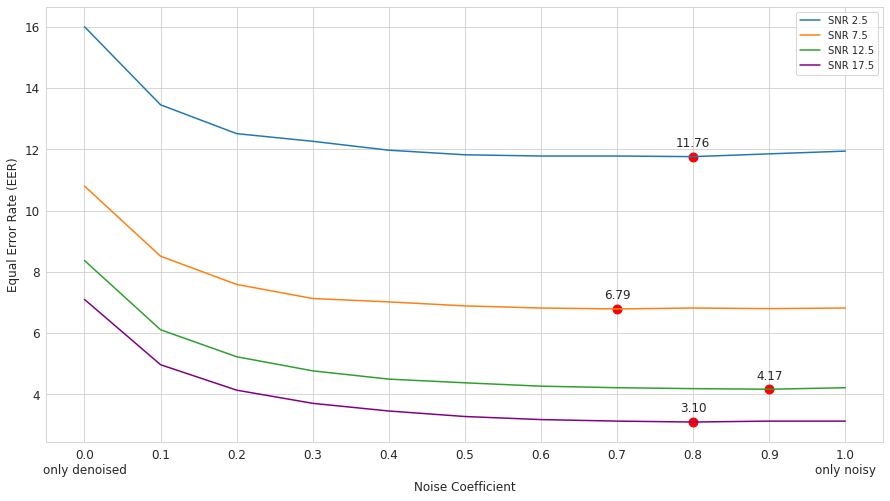

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (15, 8))
plt.plot(values_25, label = 'SNR 2.5')
plt.plot(values_75, label = 'SNR 7.5')
plt.plot(values_125, label = 'SNR 12.5')
plt.plot(values_175, label = 'SNR 17.5', color = 'purple')
plt.scatter(y = ys,
            x = xs,
            color = 'red',
            alpha = 1,
            s = 80)
for x, y in zip(xs, ys):
  label = '{:.2f}'.format(y)
  plt.annotate(label, 
               (x, y),
               textcoords = 'offset points',
               xytext = (0, 10),
               ha = 'center',
               size = 12)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels = x_axis, size = 12)
plt.yticks(size = 12)
plt.xlabel('Noise Coefficient', size = 12)
plt.ylabel('Equal Error Rate (EER)', size = 12)
plt.legend()
#plt.savefig('../plots/GridSearchNoiseCoeff.png')

In [ ]:
if eval == True:   
    sc, lab = s.comparativeEvaluationFromList(test_list_25, noise_coeff = 0.0, model = model, print_interval=100, test_path=test_path)
    result = tuneThresholdfromScore(sc, lab, [1, 0.1])
    print('EER %2.4f'%result[1])

Reading 4700: 0.25 Hz, embed size 512
Computing 37700: 1736.83 Hz

EER 30.7582


In [ ]:
noise_coeffs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_dict = {}
for noise_coeff in noise_coeffs:
  print('Evaluation with noise_coeff {}\n'.format(noise_coeff))
  if eval == True:   
    sc, lab = s.comparativeEvaluationFromList(test_list_175, noise_coeff = noise_coeff, snr = 17.5, print_interval=100, test_path=test_path)
    result = tuneThresholdfromScore(sc, lab, [1, 0.1])
    results_dict[noise_coeff] = result[1]
    print('EER %2.4f'%result[1])

Evaluation with noise_coeff 0.0

Reading 4700: 1.09 Hz, embed size 512
Computing 37700: 2803.82 Hz

EER 7.1050
Evaluation with noise_coeff 0.1

Reading 4700: 33.52 Hz, embed size 512
Computing 37700: 2819.02 Hz

EER 4.9735
Evaluation with noise_coeff 0.2

Reading 4700: 33.62 Hz, embed size 512
Computing 37700: 2778.37 Hz

EER 4.1463
Evaluation with noise_coeff 0.3

Reading 4700: 33.54 Hz, embed size 512
Computing 37700: 2698.95 Hz

EER 3.7169
Evaluation with noise_coeff 0.4

Reading 4700: 33.38 Hz, embed size 512
Computing 37700: 2839.82 Hz

EER 3.4624
Evaluation with noise_coeff 0.5

Reading 4700: 33.70 Hz, embed size 512
Computing 37700: 2723.28 Hz

EER 3.2874
Evaluation with noise_coeff 0.6

Reading 4700: 33.53 Hz, embed size 512
Computing 37700: 2717.01 Hz

EER 3.1813
Evaluation with noise_coeff 0.7

Reading 4700: 33.51 Hz, embed size 512
Computing 37700: 2718.03 Hz

EER 3.1336
Evaluation with noise_coeff 0.8

Reading 4700: 33.52 Hz, embed size 512
Computing 37700: 2825.86 Hz

EER 

<hr>

In [6]:
%pwd

'/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

In [16]:
clean_audio, _ = librosa.load('/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/id10270/5r0dWxy17C8/00001.wav', sr = 16000)
noisy_audio, _ = librosa.load('/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/id10270/5r0dWxy17C8/00001_2.5.wav', sr = 16000)

In [11]:
!pip install pesq

     |████████████████████████████████| 81kB 2.1MB/s 
  Created wheel for pesq: filename=pesq-0.0.1-cp36-cp36m-linux_x86_64.whl size=161222 sha256=faf741b8c163931cd6cb9c54fce02c1a855f78f5a2f02a856d7011d600a11905
  Stored in directory: /root/.cache/pip/wheels/42/a8/44/839b6f59a7d142d84ff06bfabaaad2a3e60408ee153de9bf13
Successfully built pesq


In [12]:
from pesq import pesq

In [24]:
with torch.no_grad():
  model.eval()
  denoised_audio = model(torch.from_numpy(noisy_audio).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0))

In [25]:
denoised_audio = denoised_audio.squeeze(0).squeeze(0).numpy()

In [30]:
pesq(16000, clean_audio, denoised_audio, 'wb')

1.090342402458191